# Compare downstream of fine-tuned model vs direct transfer of BrainLM on development dataset

The development dataset and the prediction workflow is adopted from MAIN educational workshop on Nilearn.

This dataset is an easy target as there's a known bias: the coverage of the brain scan betwenn kids and adults are different in the cerebellum.
When using an atlas that covers the cerebellum to extract features, the classification task should easily overfit.

Since BrainLM uses an atlas that covers cerebellum, this is a good dataset to test if the features got through direct transfer is anything useful.

The BrainLM model used: 650M.

In [11]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from datasets import load_from_disk
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

In [12]:
def pca_svc(C, x, y):
    """
    Extract the top 5 principal components and use a SVM to predict categorical
    label, 3 fold CV.
    """
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('pca', PCA(n_components=5)), 
        ('svc', SVC(C=C, class_weight='balanced'))
    ])
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
    scores = cross_val_score(pipe, x, y, cv=cv)
    y_pred = cross_val_predict(pipe, x, y, cv=cv)

    overall_acc = accuracy_score(y_pred=y_pred, y_true=y)
    overall_cr = classification_report(y_pred=y_pred, y_true=y)
    overall_cm = confusion_matrix(y_pred=y_pred, y_true=y)
    print('Overall Accuracy:', overall_acc)
    print(overall_cr)

    thresh = overall_cm.max() / 2
    cmdf = pd.DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
    sns.heatmap(cmdf, cmap='copper', annot=cmdf, vmax=thresh, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Observed')
    

## Loading data

When creating baseline with functional connectivity, use the labels from direct transfer.

In [13]:
# load data
features_direct = load_from_disk("../outputs/development_fmri_gigaconnectome_a424_650M/direct_transfer.arrow")
features_finetune = load_from_disk("../outputs/development_fmri_gigaconnectome_a424_650M/finetuning_transfer.arrow")

correlation_measure = ConnectivityMeasure(
    kind="correlation", vectorize=True, discard_diagonal=True
)
ts = [np.array(example).reshape(3, 424, 160)[0].T for example in features_direct['padded_recording']]
fc_direct = correlation_measure.fit_transform(ts)

## Functional connectivity

This is know to be a simple task.

Overall Accuracy: 0.9419354838709677
              precision    recall  f1-score   support

       adult       0.88      0.85      0.86        33
       child       0.96      0.97      0.96       122

    accuracy                           0.94       155
   macro avg       0.92      0.91      0.91       155
weighted avg       0.94      0.94      0.94       155



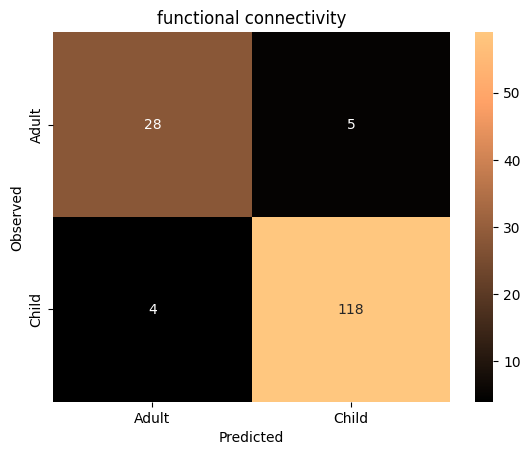

In [14]:
plt.figure()
plt.title("functional connectivity")
pca_svc(1000, fc_direct, np.array(features_direct['Child_Adult']))

## Direct transfer

Overall Accuracy: 0.5161290322580645
              precision    recall  f1-score   support

       adult       0.25      0.64      0.36        33
       child       0.83      0.48      0.61       122

    accuracy                           0.52       155
   macro avg       0.54      0.56      0.49       155
weighted avg       0.71      0.52      0.56       155



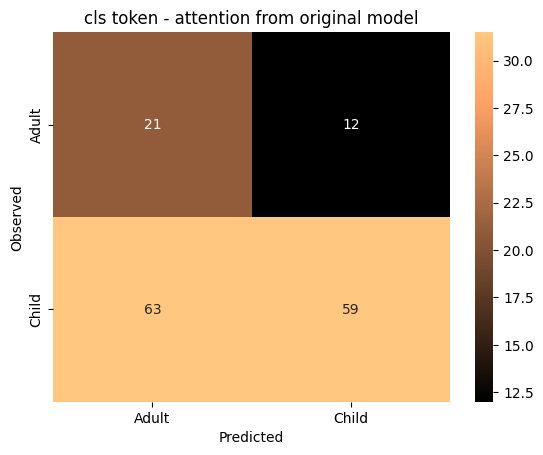

In [15]:
plt.figure()
plt.title("cls token - attention from original model")
pca_svc(1, np.array(features_direct['cls_token']).squeeze(), np.array(features_direct['Child_Adult']))

Overall Accuracy: 0.7483870967741936
              precision    recall  f1-score   support

       adult       0.44      0.67      0.53        33
       child       0.90      0.77      0.83       122

    accuracy                           0.75       155
   macro avg       0.67      0.72      0.68       155
weighted avg       0.80      0.75      0.76       155



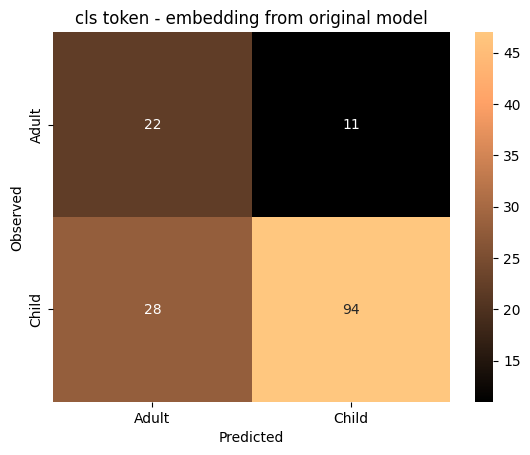

In [16]:
plt.figure()
plt.title("cls token - embedding from original model")
pca_svc(1, np.array(features_direct['cls_embedding']).squeeze(), np.array(features_direct['Child_Adult']))

## Fine tuned

Overall Accuracy: 0.43870967741935485
              precision    recall  f1-score   support

       adult       0.25      0.79      0.37        33
       child       0.86      0.34      0.49       122

    accuracy                           0.44       155
   macro avg       0.55      0.57      0.43       155
weighted avg       0.73      0.44      0.47       155



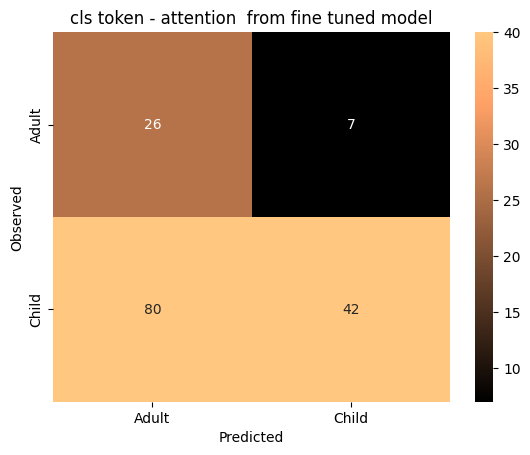

In [17]:
plt.figure()
plt.title("cls token - attention  from fine tuned model")
pca_svc(1, np.array(features_finetune['cls_token']).squeeze(), np.array(features_finetune['Child_Adult']))

Overall Accuracy: 0.8129032258064516
              precision    recall  f1-score   support

       adult       0.54      0.76      0.63        33
       child       0.93      0.83      0.87       122

    accuracy                           0.81       155
   macro avg       0.74      0.79      0.75       155
weighted avg       0.85      0.81      0.82       155



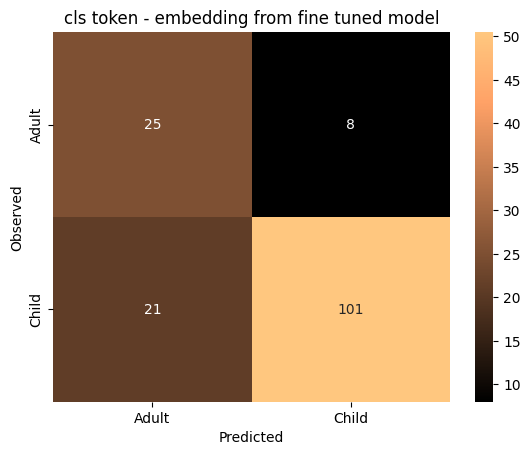

In [18]:
plt.figure()
plt.title("cls token - embedding from fine tuned model")
pca_svc(1, np.array(features_finetune['cls_embedding']).squeeze(), np.array(features_finetune['Child_Adult']))

Overall Accuracy: 0.7935483870967742
              precision    recall  f1-score   support

       adult       0.51      0.76      0.61        33
       child       0.92      0.80      0.86       122

    accuracy                           0.79       155
   macro avg       0.72      0.78      0.73       155
weighted avg       0.84      0.79      0.81       155



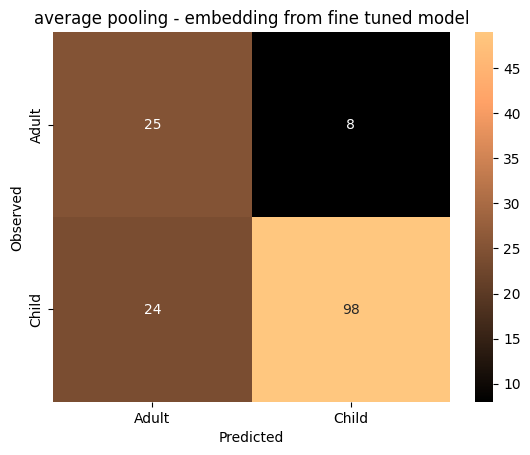

In [19]:
plt.figure()
plt.title("average pooling - embedding from fine tuned model")
pca_svc(1, np.array(features_finetune['mean_embedding']).squeeze(), np.array(features_finetune['Child_Adult']))

Overall Accuracy: 0.8258064516129032
              precision    recall  f1-score   support

       adult       0.56      0.82      0.67        33
       child       0.94      0.83      0.88       122

    accuracy                           0.83       155
   macro avg       0.75      0.82      0.77       155
weighted avg       0.86      0.83      0.84       155



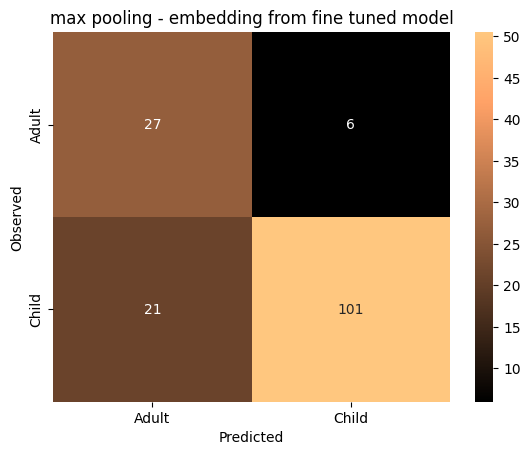

In [20]:
plt.figure()
plt.title("max pooling - embedding from fine tuned model")
pca_svc(1, np.array(features_finetune['max_embedding']).squeeze(), np.array(features_finetune['Child_Adult']))